## Gate Cutting to Reduce Circuit Width

In [1]:
import numpy as np
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import PauliList
from qiskit_aer.primitives import Estimator, Sampler

from circuit_knitting_toolbox.circuit_cutting import (
    partition_problem,
    execute_experiments,
    reconstruct_expectation_values,
)

### Create a circuit to cut

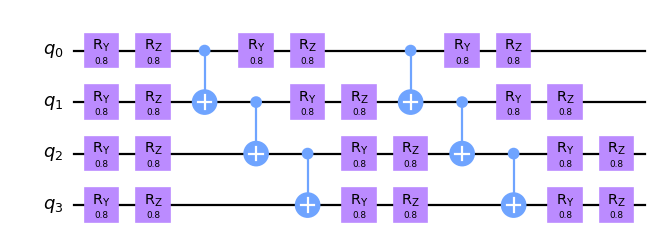

In [2]:
circuit = EfficientSU2(4, entanglement="linear", reps=2).decompose()
circuit.assign_parameters([0.8] * len(circuit.parameters), inplace=True)

circuit.draw("mpl", scale=0.8)

### Specify some observables for which we wish to simulate expectation values

In [3]:
observables = PauliList(["ZZII", "IZZI", "IIZZ", "XIXI", "ZIZZ", "IXIX"])

### Decompose the circuit and observables according to a specified qubit partitioning using `partition_problem`

Each label in `partition_labels` corresponds to the `circuit` qubit in the same index. Qubits sharing a common partition label will be grouped together, and non-local gates spanning more than one partition will be cut.
    

`partition_problem` returns dictionaries mapping partition labels to subcircuits and subobservables which have been separated along the partition boundaries. The subcircuits' cut gates have been replaced by ``SingleQubitQPDGate``s. For convenience, the ``QPDBasis`` instances from each gate decomposition are also returned.

In [4]:
subcircuits, subobservables, bases = partition_problem(
    circuit=circuit, partition_labels="AABB", observables=observables
)

### Calculate the sampling overhead for the chosen cuts

In [5]:
print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

Sampling overhead: 81.0


### Generate and run the cutting experiments using `execute_experiments`

`execute_experiments` accepts `circuits`/`observables` args as dictionaries mapping qubit partition labels to the respective `subcircuit`/`subobservables`.

To simulate the expectation value of the full-sized circuit, many subexperiments are generated from the decomposed gates' joint quasiprobability distribution and then executed on one or more backends. The number of samples to take from the distribution may be specified by `num_samples`. A `Sampler` may be specified to use for all subexperiments, or users may specify a `Sampler` for each qubit partition through a dictionary, as shown below.

`execute_experiments` returns a 3D list of length-2 tuples containing a quasiprobability distribution and QPD bit information for each unique subexperiment. The coefficients for each subexperiment are also returned. If the number of samples taken could cover the entire distribution, the returned coefficients will be exact with respect to the  decomposed gates' joint quasiprobability distribution.

In [6]:
%%capture

############
# Python's GIL will prevent the parallelization of these subexperiments from
# providing a speedup when run *locally*. Use Qiskit Runtime to run
# subexperiments in parallel
############

# Specify a Sampler for each qubit partition
samplers = {
    "A": Sampler(run_options={"shots": None}),
    "B": Sampler(run_options={"shots": None}),
}

quasi_dists, coefficients = execute_experiments(
    circuits=subcircuits,
    observables=subobservables,
    num_samples=1500,
    samplers=samplers,
)

### Reconstruct the simulated expectation values using `reconstruct_expectation_values`

`reconstruct_expectation_values` expects `quasi_dists` and `coefficients` in the same format as returned from `execute_experiments`. `quasi_dists` is a 3D list of shape `(num_unique_samples, num_partitions, num_commuting_observ_groups)`, and `coefficients` is a list of length `num_unique_samples`. `subobservables` is the dictionary mapping qubit partition label to the associated subobservable(s), as output from `decompose_problem` above.

The output of `reconstruct_expectation_values` is a list of simulated expectation values -- one for each observable.

In [7]:
simulated_expvals = reconstruct_expectation_values(
    quasi_dists,
    coefficients,
    subobservables,
)

### Compare the simulated expectation values with the exact expectation value from the original circuit

Statevector-based Samplers were used in this tutorial which results in exact expectation values for each subexperiment. Additionally, the number of samples taken from the joint quasiprobability distribution was sufficient to allow for exact QPD sampling weight to be calculated and used during reconstruction.

Calculating the sub-expectation values exactly and reconstructing them using exact weights should yield an exact reconstruction of the expectation value of the full circuit and observable.

In [8]:
estimator = Estimator(run_options={"shots": None}, approximation=True)
exact_expvals = (
    estimator.run([circuit] * len(observables), list(observables)).result().values
)
print(
    f"Simulated expectation values: {[round(simulated_expvals[i], 8) for i in range(len(exact_expvals))]}"
)
print(
    f"Exact expectation values: {[round(exact_expvals[i], 8) for i in range(len(exact_expvals))]}"
)
print(
    f"Errors in estimation: {[round(simulated_expvals[i]-exact_expvals[i], 8) for i in range(len(exact_expvals))]}"
)

Simulated expectation values: [0.17153613, 0.1815846, 0.30958691, 0.44036036, 0.08173037, 0.70623815]
Exact expectation values: [0.17153613, 0.1815846, 0.30958691, 0.44036036, 0.08173037, 0.70623815]
Errors in estimation: [-0.0, 0.0, 0.0, -0.0, 0.0, 0.0]
